## Data prep and Logistic regression

In [1]:
import time
import os

import IPython.display as ipd
# from tqdm import tqdm_notebook
from tqdm import notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from scipy import interp
from sklearn.metrics import roc_auc_score

import utils

# from catboost import CatBoostClassifier
import collections
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "8" #please put your GPU

In [3]:
tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')
genres = utils.load('genres.csv')

tracks.shape, features.shape, echonest.shape, genres.shape

((106574, 52), (106574, 518), (13129, 249), (163, 4))

In [4]:
# !ls /aml/notebook/audio/fma_small/153
# Audio("/aml/notebook/audio/fma_small/153/153452.mp3", autoplay=True)

# Preprocessing

In [34]:
#def map_genre_id(genre_top):
#    genre_id = genres[genres.title==genre_top].index.values.astype(int)[0]
#    return genre_id


def preprocess(df):
    # Add genre_top, split, subset from track to features
    df_tracks = tracks
    genre_top = df_tracks.track.genre_top
    split = df_tracks.set.split
    subset = df_tracks.set.subset
    df = pd.concat([df, genre_top, split, subset], axis=1)
    df = df.dropna(subset=['genre_top'])
    
    # Remove genres with less than 1000 entries
#     counts = df['genre_top'].value_counts()
#     df = df[~df['genre_top'].isin(counts[counts < 1000].index)]
#     df.genre_top.unique()
    return df


def oversampling(X, y):
    print('before oversampling:', collections.Counter(y))
    
    oversample = RandomOverSampler(sampling_strategy='auto')
    X_over, y_over = oversample.fit_resample(X, y)
    a = np.array(y_over)
    print('after oversampling:', collections.Counter(a))
    
    y_over = pd.Series(y_over)
    return X_over, y_over


def undersampling(X, y):
    print('before undersampling:', collections.Counter(y))
    
    undersample = RandomUnderSampler(sampling_strategy='auto')
    X_under, y_under = undersample.fit_resample(X, y)
    a = np.array(y_under)
    print('after undersampling:', collections.Counter(a))
    
    y_under = pd.Series(y_under)
    return X_under, y_under


def mixsampling(X, y):
    strategy = {'Hip-Hop':6000, 'Folk':6000, 'Pop':6000, 'Instrumental':6000, 'Classical':6000, 'International':6000}
    print('before sampling:', collections.Counter(y))
    smote=SMOTE(sampling_strategy=strategy)
    X, y=smote.fit_resample(X, y)
    print('after oversampling:', collections.Counter(y))
    
    strategy = {'Rock':6000, 'Experimental':6000, 'Electronic':6000}
    undersample = RandomUnderSampler(sampling_strategy=strategy)
    X, y = undersample.fit_resample(X, y)
    print('after undersampling:', collections.Counter(y))
    return X, y


def apply_PCA(df):   
    # Keep needed features, to be added back after PCA
    genre_top = df.genre_top
    index = df.index
    split = df.split
    subset = df.subset
    df = df.drop(columns=['genre_top', 'split', 'subset'])

    # Scale the features and set the values to a new variable
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(df)
    
    # Get our explained variance ratios from PCA using all features
    pca = PCA(n_components = 0.95)
    pca.fit(scaled_train_features)
    exp_variance = pca.explained_variance_ratio_
    reduced = pca.transform(scaled_train_features)

    # plot the explained variance using a barplot
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.bar(range(pca.n_components_), exp_variance)
    ax.set_xlabel('Principal Component #')
    
    df = pd.DataFrame(reduced)
    df.index = index
    df = pd.concat([df, genre_top, split, subset], axis=1)
    return df

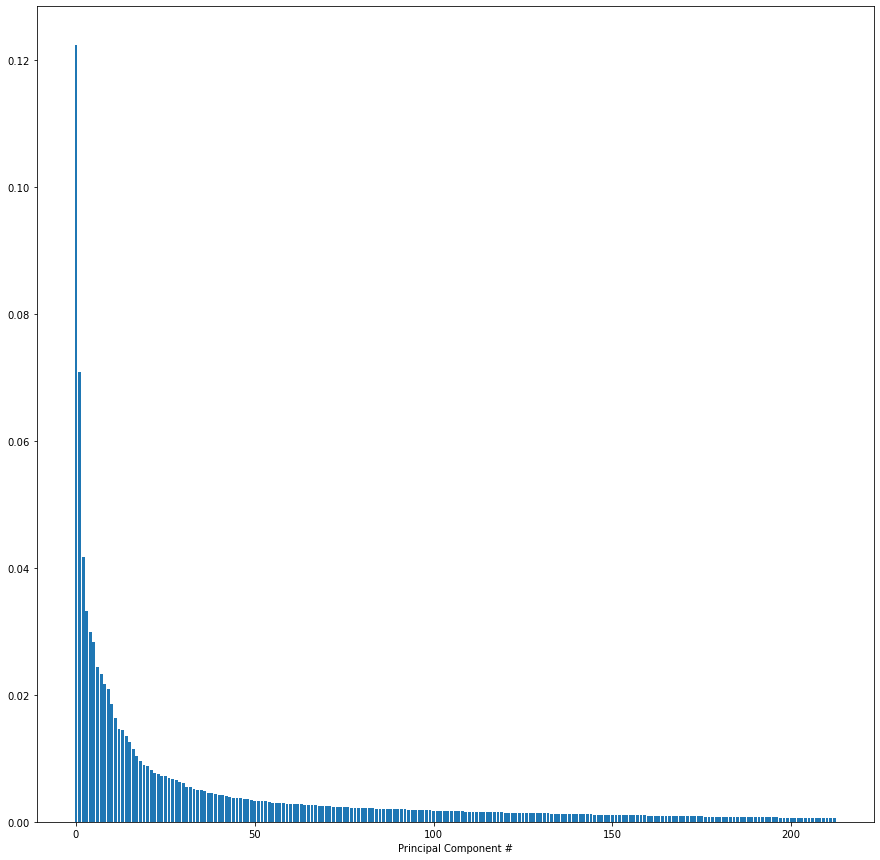

In [35]:
df_processed = preprocess(features)
df_postPCA = apply_PCA(df_processed)

# X = df_processed.drop(columns=['genre_top', 'split', 'subset'])
# y = df_processed['genre_top','split']
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [37]:
symbols = df_postPCA.groupby('genre_top')

In [38]:
symbols['genre_top'].agg(['count']).sort_values(['count'], ascending=False)

,count
genre_top,
Rock,14182
Experimental,10608
Electronic,9372
Hip-Hop,3552
Folk,2803
Pop,2332
Instrumental,2079
International,1389
Classical,1230


In [7]:
df_processed.shape

(47547, 521)

In [8]:
df_postPCA.shape

(47547, 216)

In [9]:
# df_postPCA["genre_top"].groupby().agg(['count'])

In [10]:
# X_train = df_processed[df_processed['split'] == 'training'].drop(columns=['genre_top', 'split', 'subset'])
# X_val= df_processed[df_processed['split'] == 'validation'].drop(columns=['genre_top', 'split', 'subset'])
# X_test = df_processed[df_processed['split'] == 'test'].drop(columns=['genre_top', 'split', 'subset'])

# y_train = df_processed[df_processed['split'] == 'training']['genre_top']
# y_val= df_processed[df_processed['split'] == 'validation']['genre_top']
# y_test = df_processed[df_processed['split'] == 'test']['genre_top']


In [11]:
X_train = df_postPCA[df_postPCA['split'] == 'training'].drop(columns=['genre_top', 'split', 'subset'])
X_val= df_postPCA[df_postPCA['split'] == 'validation'].drop(columns=['genre_top', 'split', 'subset'])
X_test = df_postPCA[df_postPCA['split'] == 'test'].drop(columns=['genre_top', 'split', 'subset'])

y_train = df_postPCA[df_postPCA['split'] == 'training']['genre_top']
y_val= df_postPCA[df_postPCA['split'] == 'validation']['genre_top']
y_test = df_postPCA[df_postPCA['split'] == 'test']['genre_top']


In [12]:
X_over, y_over = oversampling(X_train, y_train)

before oversampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after oversampling: Counter({'Hip-Hop': 11394, 'Pop': 11394, 'Rock': 11394, 'Experimental': 11394, 'Folk': 11394, 'Electronic': 11394, 'International': 11394, 'Classical': 11394, 'Instrumental': 11394})


In [13]:
X_under, y_under = undersampling(X_train, y_train)

before undersampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after undersampling: Counter({'Classical': 1069, 'Electronic': 1069, 'Experimental': 1069, 'Folk': 1069, 'Hip-Hop': 1069, 'Instrumental': 1069, 'International': 1069, 'Pop': 1069, 'Rock': 1069})


In [14]:
X_mix, y_mix = mixsampling(X_train, y_train)

before sampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 2910, 'Folk': 2275, 'Pop': 1815, 'Instrumental': 1579, 'International': 1124, 'Classical': 1069})
after oversampling: Counter({'Rock': 11394, 'Experimental': 8557, 'Electronic': 7662, 'Hip-Hop': 6000, 'Pop': 6000, 'Folk': 6000, 'International': 6000, 'Classical': 6000, 'Instrumental': 6000})
after undersampling: Counter({'Classical': 6000, 'Electronic': 6000, 'Experimental': 6000, 'Folk': 6000, 'Hip-Hop': 6000, 'Instrumental': 6000, 'International': 6000, 'Pop': 6000, 'Rock': 6000})


## Logistic Regression

### OVR

### No sampling

In [ ]:
# Grid search cross validation
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
# logreg=LogisticRegression()
# logreg_cv=GridSearchCV(logreg,grid,cv=10)
# logreg_cv.fit(X_train,y_train)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
ovr_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='ovr', max_iter = 1000)
ovr_estimator_cv=GridSearchCV(ovr_estimator,grid,cv=10)
ovr_estimator_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",ovr_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
from sklearn import linear_model, model_selection, metrics

# Fit a multi-class logistic regression model with one-v.s.-rest
ovr_estimator = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='ovr',
    C = 10.0, penalty = 'l2', max_iter = 1000)
ovr_estimator.fit(X_train, y_train)

ovr_predict = ovr_estimator.predict(X_test)
ovr_predict_proba = ovr_estimator.predict_proba(X_test)

ovr_report = f"""
The evaluation report of OVR is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, ovr_predict)}
Accuracy: {round(metrics.accuracy_score(y_test, ovr_predict), 3)}
"""
print(ovr_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y_test, ovr_predict)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('accuracy:', metrics.accuracy_score(y_test, ovr_predict))
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(ovr_estimator, X_test, y_test, ax=ax) 

In [ ]:
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(names))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
from itertools import product

def plot_confusion_matrix(cm, names, title='FMA LR - Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
labelNames = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
labelNames.sort()

In [ ]:
nosample_confusion_matrix_ovr = metrics.confusion_matrix(y_test, ovr_predict)

In [ ]:
print(nosample_confusion_matrix_ovr)
plt.figure()
plot_confusion_matrix(nosample_confusion_matrix_ovr, labelNames)
plt.show()

### Under sampling

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
ovr_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='ovr', max_iter = 1000)
ovr_estimator_cv=GridSearchCV(ovr_estimator,grid,cv=10)
ovr_estimator_cv.fit(X_under, y_under)

print("tuned hpyerparameters :(best parameters) ",ovr_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
from sklearn import linear_model, model_selection, metrics

# Fit a multi-class logistic regression model with one-v.s.-rest
ovr_estimator = linear_model.LogisticRegression()
#     solver='lbfgs',
#     multi_class='ovr', 
#     C = 0.01, max_iter = 1000)
ovr_estimator.fit(X_under, y_under)

ovr_predict_under = ovr_estimator.predict(X_test)
ovr_predict_under_proba = ovr_estimator.predict_proba(X_test)

ovr_report = f"""
The evaluation report of OVR is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, ovr_predict_under)}
Accuracy: {round(metrics.accuracy_score(y_test, ovr_predict_under), 3)}
"""
print(ovr_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y_test, ovr_predict_under)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('accuracy:', metrics.accuracy_score(y_test, ovr_predict_under))
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(ovr_estimator, X_test, y_test, ax=ax) 

In [ ]:
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(names))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
from itertools import product

def plot_confusion_matrix(cm, names, title='FMA LR - Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
undersample_confusion_matrix_ovr = metrics.confusion_matrix(y_test, ovr_predict_under)

In [ ]:
print(undersample_confusion_matrix_ovr)
plt.figure()
plot_confusion_matrix(undersample_confusion_matrix_ovr, labelNames)
plt.show()

### Over sampling

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
ovr_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='ovr', max_iter = 1000)
ovr_estimator_cv=GridSearchCV(ovr_estimator,grid,cv=10)
ovr_estimator_cv.fit(X_over, y_over)

print("tuned hpyerparameters :(best parameters) ",ovr_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
from sklearn import linear_model, model_selection, metrics

# Fit a multi-class logistic regression model with one-v.s.-rest
ovr_estimator = linear_model.LogisticRegression()
#     solver='lbfgs',
#     multi_class='ovr', 
#     C = 0.1, max_iter = 1000)
ovr_estimator.fit(X_over, y_over)

ovr_predict_over = ovr_estimator.predict(X_test)
ovr_predict_over_proba = ovr_estimator.predict_proba(X_test)

ovr_report = f"""
The evaluation report of OVR is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, ovr_predict_over)}
Accuracy: {round(metrics.accuracy_score(y_test, ovr_predict_over), 3)}
"""
print(ovr_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y_test, ovr_predict_over)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('accuracy:', metrics.accuracy_score(y_test, ovr_predict_over))
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(ovr_estimator, X_test, y_test, ax=ax) 

In [ ]:
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(names))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
from itertools import product

def plot_confusion_matrix(cm, names, title='FMA DT - Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
oversample_confusion_matrix_ovr = metrics.confusion_matrix(y_test, ovr_predict_over)

In [ ]:
ovr_predict_over

In [ ]:
print(oversample_confusion_matrix_ovr)
plt.figure()
plot_confusion_matrix(oversample_confusion_matrix_ovr, labelNames)
plt.show()

### Mix sampling

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
ovr_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='ovr', max_iter = 1000)
ovr_estimator_cv=GridSearchCV(ovr_estimator,grid,cv=10)
ovr_estimator_cv.fit(X_over, y_over)

print("tuned hpyerparameters :(best parameters) ",ovr_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
from sklearn import linear_model, model_selection, metrics

# Fit a multi-class logistic regression model with one-v.s.-rest
ovr_estimator = linear_model.LogisticRegression()
#     solver='lbfgs',
#     multi_class='ovr', 
#     C = 0.1, max_iter = 1000)
ovr_estimator.fit(X_mix, y_mix)

ovr_predict_mix = ovr_estimator.predict(X_test)
ovr_predict_mix_proba = ovr_estimator.predict_proba(X_test)

ovr_report = f"""
The evaluation report of OVR is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, ovr_predict_mix)}
Accuracy: {round(metrics.accuracy_score(y_test, ovr_predict_mix), 3)}
"""
print(ovr_report)
print('The classification report of OVR:\n {}'
      .format(metrics.classification_report(y_test, ovr_predict_mix)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('accuracy:', metrics.accuracy_score(y_test, ovr_predict_over))
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(ovr_estimator, X_test, y_test, ax=ax) 

In [ ]:
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(names))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [ ]:
from itertools import product

def plot_confusion_matrix(cm, names, title='FMA DT - Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
mixsample_confusion_matrix_ovr = metrics.confusion_matrix(y_test, ovr_predict_mix)

In [ ]:
ovr_predict_mix

In [ ]:
print(mixsample_confusion_matrix_ovr)
plt.figure()
plot_confusion_matrix(mixsample_confusion_matrix_ovr, labelNames)
plt.show()

In [ ]:
print("One Vs Rest logistic regression metrics:\n")

print("ovr_nosampling_recall: ", metrics.recall_score(y_test,ovr_predict, average = 'weighted'))
print("ovr_nosampling_precision: ", metrics.precision_score(y_test,ovr_predict, average = 'weighted'))
print("ovr_nosampling_f1_Score: ", metrics.f1_score(y_test,ovr_predict, average = 'weighted'))
print("ovr_nosampling_accuracy: ", metrics.accuracy_score(y_test,ovr_predict))
print('ovr_nosampling_AUC:', metrics.roc_auc_score(y_test,ovr_predict_proba, multi_class='ovr', average='weighted'), "\n")

print("ovr_oversampling_recall: ", metrics.recall_score(y_test,ovr_predict_over, average = 'weighted'))
print("ovr_oversampling_precision: ", metrics.precision_score(y_test,ovr_predict_over, average = 'weighted'))
print("ovr_oversampling_f1_Score: ", metrics.f1_score(y_test,ovr_predict_over, average = 'weighted'))
print("ovr_oversampling_accuracy: ", metrics.accuracy_score(y_test,ovr_predict_over))
print('ovr_oversampling_AUC:', metrics.roc_auc_score(y_test, ovr_predict_over_proba, multi_class='ovr', average='weighted'), "\n")

print("ovr_undersampling_recall: ", metrics.recall_score(y_test,ovr_predict_under, average = 'weighted'))
print("ovr_undersampling_precision: ", metrics.precision_score(y_test,ovr_predict_under, average = 'weighted'))
print("ovr_undersampling_f1_Score: ", metrics.f1_score(y_test,ovr_predict_under, average = 'weighted'))
print("ovr_undersampling_accuracy: ", metrics.accuracy_score(y_test,ovr_predict_under))
print('ovr_undersampling_AUC:', metrics.roc_auc_score(y_test, ovr_predict_under_proba, multi_class='ovr', average='weighted'), "\n")

print("ovr_mixsampling_recall: ", metrics.recall_score(y_test,ovr_predict_mix, average = 'weighted'))
print("ovr_mixsampling_precision: ", metrics.precision_score(y_test,ovr_predict_mix, average = 'weighted'))
print("ovr_mixsampling_f1_Score: ", metrics.f1_score(y_test,ovr_predict_mix, average = 'weighted'))
print("ovr_mixsampling_accuracy: ", metrics.accuracy_score(y_test,ovr_predict_mix))
print('ovr_mixsampling_AUC:', metrics.roc_auc_score(y_test, ovr_predict_mix_proba, multi_class='ovr', average='weighted'), "\n")


In [ ]:
# from sklearn import metrics

# print('accuracy:', metrics.accuracy_score(y_test, ovr_predict))
# fig, ax = plt.subplots(figsize=(12, 12))
# plot_confusion_matrix(ovr_estimator, X_test, y_test, ax=ax) 

### Multinomial - default for multi class logistic regression

In [34]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
sm_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial', max_iter=2000)
sm_estimator_cv=GridSearchCV(sm_estimator,grid,cv=10)
sm_estimator_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",sm_estimator_cv.best_params_)
print("accuracy :",sm_estimator_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}


NameError: name 'ovr_estimator_cv' is not defined

In [19]:
from sklearn import linear_model, model_selection, metrics

# Fit a multi-class logistic regression model with softmax
sm_estimator = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    C = 0.01, penalty = 'l2', max_iter=1000)
sm_estimator.fit(X_train, y_train)

sm_predict = sm_estimator.predict(X_test)
sm_predict_proba = sm_estimator.predict_proba(X_test)

sm_report = f"""
The evaluation report of Softmax is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, sm_predict)}
Accuracy: {round(metrics.accuracy_score(y_test, sm_predict), 3)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, sm_predict)))


The evaluation report of Softmax is:
Confusion Matrix:
[[  64    0   14    1    0    5    0    1    2]
 [   2  572  129    3   37    7    4   12   73]
 [   4  120  695   31   17   15    3   11  189]
 [   2    5   96   79    0    5    9    2  101]
 [   0   53   22    0  224    1    2    0   21]
 [   9   48   72   54    0   43    2   10   71]
 [   1   26    6   31    6    0   29    1   28]
 [   0   77   22   22   10    3    2    4   64]
 [   1   62  104   36   17    2    7   11 1224]]
Accuracy: 0.619

The classification report of Softmax:
                precision    recall  f1-score   support

    Classical       0.77      0.74      0.75        87
   Electronic       0.59      0.68      0.63       839
 Experimental       0.60      0.64      0.62      1085
         Folk       0.31      0.26      0.28       299
      Hip-Hop       0.72      0.69      0.71       323
 Instrumental       0.53      0.14      0.22       309
International       0.50      0.23      0.31       128
          Pop 

accuracy: 0.6192486281131279


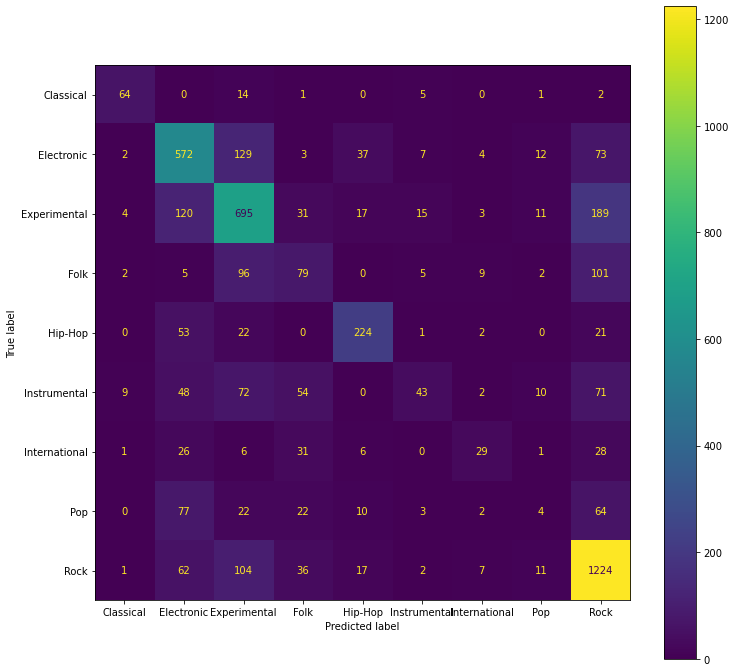

In [20]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

print('accuracy:', metrics.accuracy_score(y_test, sm_predict))
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(sm_estimator, X_test, y_test, ax=ax) 

In [21]:
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(names))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [22]:
from itertools import product

def plot_confusion_matrix(cm, names, title='FMA LR - Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
labelNames = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
labelNames.sort()

In [24]:
nosample_confusion_matrix_sm = metrics.confusion_matrix(y_test, sm_predict)

[[  64    0   14    1    0    5    0    1    2]
 [   2  572  129    3   37    7    4   12   73]
 [   4  120  695   31   17   15    3   11  189]
 [   2    5   96   79    0    5    9    2  101]
 [   0   53   22    0  224    1    2    0   21]
 [   9   48   72   54    0   43    2   10   71]
 [   1   26    6   31    6    0   29    1   28]
 [   0   77   22   22   10    3    2    4   64]
 [   1   62  104   36   17    2    7   11 1224]]


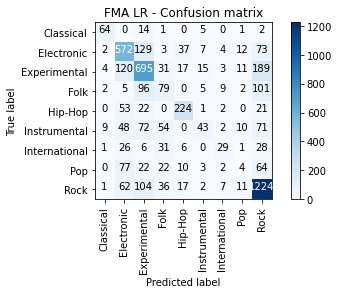

In [25]:
print(nosample_confusion_matrix_sm)
plt.figure()
plot_confusion_matrix(nosample_confusion_matrix_sm, labelNames)
plt.show()

### Under sampling

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
sm_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial', max_iter=1000)
sm_estimator_cv=GridSearchCV(sm_estimator,grid,cv=10)
sm_estimator_cv.fit(X_under, y_under)

print("tuned hpyerparameters :(best parameters) ",sm_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
# Fit a multi-class logistic regression model with softmax
sm_estimator = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=100)
sm_estimator.fit(X_under, y_under)

sm_predict_under = sm_estimator.predict(X_test)
sm_predict_under_proba = sm_estimator.predict_proba(X_test)

sm_report = f"""
The evaluation report of Softmax is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, sm_predict_under)}
Accuracy: {round(metrics.accuracy_score(y_test, sm_predict_under), 3)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, sm_predict_under)))

### Over sampling

In [ ]:
# Grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2","none"]}# l1 lasso l2 ridge
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#‘lbfgs’ only handle L2 or no penalty
sm_estimator = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial', max_iter=1000)
sm_estimator_cv=GridSearchCV(sm_estimator,grid,cv=10)
sm_estimator_cv.fit(X_over, y_over)

print("tuned hpyerparameters :(best parameters) ",sm_estimator_cv.best_params_)
print("accuracy :",ovr_estimator_cv.best_score_)

In [ ]:
# Fit a multi-class logistic regression model with softmax
sm_estimator = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=100)
sm_estimator.fit(X_over, y_over)

sm_predict_over = sm_estimator.predict(X_test)
sm_predict_over_proba = sm_estimator.predict_proba(X_test)

sm_report = f"""
The evaluation report of Softmax is:
Confusion Matrix:
{metrics.confusion_matrix(y_test, sm_predict_over)}
Accuracy: {round(metrics.accuracy_score(y_test, sm_predict_over), 3)}
"""
print(sm_report)
print('The classification report of Softmax:\n {}'
      .format(metrics.classification_report(y_test, sm_predict_over)))

In [26]:
print("Softmax logistic regression metrics:\n")

print("sm_nosampling_recall: ", metrics.recall_score(y_test,sm_predict, average = 'weighted'))
print("sm_nosampling_precision: ", metrics.precision_score(y_test,sm_predict, average = 'weighted'))
print("sm_nosampling_f1_Score: ", metrics.f1_score(y_test,sm_predict, average = 'weighted'))
print("sm_nosampling_accuracy: ", metrics.accuracy_score(y_test,sm_predict))
print('sm_nosampling_AUC:', metrics.roc_auc_score(y_test, sm_predict_proba, multi_class='ovr', average='weighted'), "\n")

# print("sm_undersampling_recall: ", metrics.recall_score(y_test,sm_predict_under, average = 'weighted'))
# print("sm_undersampling_precision: ", metrics.precision_score(y_test,sm_predict_under, average = 'weighted'))
# print("sm_undersampling_f1_Score: ", metrics.f1_score(y_test,sm_predict_under, average = 'weighted'))
# print("sm_undersampling_accuracy: ", metrics.accuracy_score(y_test,sm_predict_under))
# print('sm_undersampling_AUC:', metrics.roc_auc_score(y_test, sm_predict_under_proba, multi_class='ovr', average='weighted'), "\n")

# print("sm_oversampling_recall: ", metrics.recall_score(y_test,sm_predict_over, average = 'weighted'))
# print("sm_oversampling_precision: ", metrics.precision_score(y_test,sm_predict_over, average = 'weighted'))
# print("sm_oversampling_f1_Score: ", metrics.f1_score(y_test,sm_predict_over, average = 'weighted'))
# print("sm_oversampling_accuracy: ", metrics.accuracy_score(y_test,sm_predict_over))
# print('sm_oversampling_AUC:', metrics.roc_auc_score(y_test, sm_predict_over_proba, multi_class='ovr', average='weighted'), "\n")

Softmax logistic regression metrics:

sm_nosampling_recall:  0.6192486281131279
sm_nosampling_precision:  0.5897971645766695
sm_nosampling_f1_Score:  0.5919628963413716
sm_nosampling_accuracy:  0.6192486281131279
sm_nosampling_AUC: 0.8823083887332746 



In [ ]:
# from sklearn import metrics

# print('accuracy:', metrics.accuracy_score(y_test, sm_predict))
# fig, ax = plt.subplots(figsize=(12, 12))
# plot_confusion_matrix(sm_estimator, X_test, y_test, ax=ax) 

## Plot ROC curve

In [ ]:
# y_pred_prob = logreg.predict_proba(X_test)
# # keep probabilities for the positive class only
# y_pred_prob = y_pred_prob[:, 1]

# # calculate the ROC curve
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

# # Calculate AUC
# print('AUC:', metrics.roc_auc_score(y_test, y_pred_prob)) #y_pred_prob is the probability not the predicted label

# plt.plot([0, 1], [0, 1], ls = '--')
# plt.plot(fpr, tpr, marker = '.')
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC Curve')
# plt.show()

In [27]:
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# ovr_estimator = linear_model.LogisticRegression(
#     solver='lbfgs',
#     multi_class='ovr',
#     C = 10.0, max_iter = 1000)
# ovr_estimator.fit(X_train, y_train)

# ovr_predict = ovr_estimator.predict(X_test)
# ovr_predict_proba= ovr_estimator.predict_proba(X_test)

# ovr_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

# ovr_knn.fit(reduced_train_features, y_train)

# y_pred_ovr_knn = ovr_knn.predict(reduced_test_features)
# y_pred_ovr_knn_probability = ovr_knn.predict_proba(reduced_test_features)

In [28]:
sm_estimator = linear_model.LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    C = 0.01, penalty = 'l2', max_iter=1000)
sm_estimator.fit(X_train, y_train)

sm_predict = sm_estimator.predict(X_test)
sm_predict_proba = sm_estimator.predict_proba(X_test)

# ovr_knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

# ovr_knn.fit(reduced_train_features, y_train)

# y_pred_ovr_knn = ovr_knn.predict(reduced_test_features)
# y_pred_ovr_knn_probability = ovr_knn.predict_proba(reduced_test_features)

In [29]:
sm_predict

array(['Rock', 'Rock', 'Rock', ..., 'Rock', 'Rock', 'Electronic'],
      dtype=object)

In [30]:
labelNames = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
labelNames.sort()

fpr = {}
tpr = {}
thresh ={}

n_class = 9

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, sm_predict_proba[:,i], pos_label=labelNames[i])

In [31]:
print(labelNames)

['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


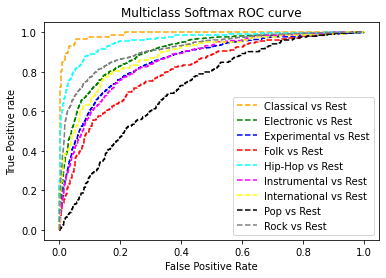

In [33]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Classical vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Electronic vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Experimental vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Folk vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='cyan', label='Hip-Hop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Instrumental vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='International vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='black', label='Pop vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='grey', label='Rock vs Rest')
plt.title('Multiclass Softmax ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

### ARCHIVE

In [ ]:
# !pip install tensorflow --user

In [ ]:
# import time
# import os

# import IPython.display as ipd
# # from tqdm import tqdm_notebook
# from tqdm import notebook
# import numpy as np
# import pandas as pd
# import keras
# from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

# from sklearn.utils import shuffle
# from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC, LinearSVC
# #from sklearn.gaussian_process import GaussianProcessClassifier
# #from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.multiclass import OneVsRestClassifier

# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize

# from scipy import interp
# from sklearn.metrics import roc_auc_score

# import utils

In [ ]:
# AUDIO_DIR = os.environ.get('AUDIO_DIR')

# tracks = utils.load('tracks.csv')
# features = utils.load('features.csv')
# echonest = utils.load('echonest.csv')

# np.testing.assert_array_equal(features.index, tracks.index)
# assert echonest.index.isin(tracks.index).all()

# tracks.shape, features.shape, echonest.shape

In [ ]:
# features.head()

## Data preparation

In [ ]:
# tracks_clean = pd.read_csv("tracks_cleaned.csv")

# tracks_clean = tracks_clean[['track_id','genre_top','split','subset']]

# tracks_clean.head()

# tracks_clean.shape

# tracks_clean.isna().sum(axis=0)

In [ ]:
# tracks = pd.read_csv("tracks.csv")

# # tracks = tracks[['track_id','genre_top','split','subset']]

# tracks.head()

# tracks.shape

# tracks_clean.isna().sum(axis=0)

In [ ]:
# genres = ["Rock","Experimental","Electronic","Hip-Hop","Folk","Pop","Instrumental","International","Classical"]
# tracks_clean = tracks_clean[tracks_clean.genre_top.isin(genres)]
# tracks_clean.shape

In [ ]:
# tracks_clean.dropna(subset = ["genre_top","track_id","split","subset"], inplace=True)

# tracks_clean.isna().sum(axis=0)

# tracks_clean.shape

In [ ]:
# tracks_clean[["genre_top","track_id","split","subset"]].groupby(["genre_top"]).agg(['count'])

In [ ]:
# tracks_clean

In [ ]:
# # Read in librosa track features
# features = pd.read_csv("features_cleaned.csv")

# features.head()


In [ ]:
# features

In [ ]:
# Merge the relevant columns of tracks and features

# tracks_clean['track_id'] = tracks_clean['track_id'].astype(int)
# features['track_id'] = features['track_id'].astype(int)

# tracks_features = tracks_clean.merge(features, how='left', on='track_id')
# tracks_features = features.merge(tracks_clean[['track_id','genre_top','split','subset']], on='track_id')

In [ ]:
# tracks_features.shape

In [ ]:
# tracks_features

## Split dataset

In [ ]:
# subset = tracks.index[tracks['set', 'subset'] <= 'medium']

# assert subset.isin(tracks.index).all()
# assert subset.isin(features.index).all()

# features_all = features.join(echonest, how='inner').sort_index(axis=1)
# print('Not enough Echonest features: {}'.format(features_all.shape))

# tracks = tracks.loc[subset]
# features_all = features.loc[subset]

# tracks.shape, features_all.shape

In [ ]:
# train = tracks_features[tracks_features['split'] == 'training']
# val = tracks_features[tracks_features['split'] == 'validation']
# test = tracks_features[tracks_features['split'] == 'test']

In [ ]:
# train

In [ ]:
# X_train = train.iloc[:, 4:]
# y_train = train['genre_top']

# X_val = val.iloc[:, 4:]
# y_val = val['genre_top']

# X_test = test.iloc[:, 4:]
# y_test = test['genre_top']

In [ ]:
# X_train

In [ ]:
# train = tracks_features.index[tracks_features['split'] == 'training']
# val = tracks_features.index[tracks_features['split'] == 'validation']
# test = tracks_features.index[tracks_features['split'] == 'test']

# train = tracks_features.index[tracks_features['set', 'split'] == 'training']
# val = tracks_features.index[tracks_features['set', 'split'] == 'validation']
# test = tracks_features.index[tracks_features['set', 'split'] == 'test']

# print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

# genres = list(LabelEncoder().fit(tracks_features['track', 'genre_top']).classes_)
# #genres = list(tracks['track', 'genre_top'].unique())
# print('Top genres ({}): {}'.format(len(genres), genres))
# genres = list(MultiLabelBinarizer().fit(tracks_features['track', 'genres_all']).classes_)
# print('All genres ({}): {}'.format(len(genres), genres))

In [ ]:
# enc = LabelEncoder()
# labels = tracks_features['genre_top']

# # Split in training, validation and testing sets.
# y_train = enc.fit_transform(labels[train])
# y_val = enc.transform(labels[val])
# y_test = enc.transform(labels[test])

# X_train = enc.fit_transform(features[train])
# X_val = enc.transform(features[val])
# X_test = enc.transform(features[test])

# X_train = features.loc[train].to_numpy()
# X_val = features.loc[val].to_numpy()
# X_test = features.loc[test, columns].to_numpy()
    
# X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
# Standardize features by removing the mean and scaling to unit variance.
# scaler = StandardScaler(copy=False)
# scaler.fit_transform(X_train)
# scaler.transform(X_val)
# scaler.transform(X_test)
    

In [ ]:
# y_train

## Oversampling and undersampling

In [ ]:
# !pip install imblearn

In [ ]:
# import collections
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# def oversampling(X, y):
#     print('before oversampling:', collections.Counter(y))
    
#     oversample = RandomOverSampler(sampling_strategy='auto')
#     X_over, y_over = oversample.fit_resample(X, y)
#     a = np.array(y_over)
#     print('after oversampling:', collections.Counter(a))
    
#     y_over = pd.Series(y_over)
#     return X_over, y_over

In [ ]:
# def undersampling(X, y):
#     print('before undersampling:', collections.Counter(y))
    
#     undersample = RandomUnderSampler(sampling_strategy='auto')
#     X_under, y_under = undersample.fit_resample(X, y)
#     a = np.array(y_under)
#     print('after undersampling:', collections.Counter(a))
    
#     y_under = pd.Series(y_under)
#     return X_under, y_under

In [ ]:
# X_over, y_over = oversampling(X_train, y_train)

In [ ]:
# X_under, y_under = undersampling(X_train, y_train)